# Import necessary libraries

In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
# libaries to help with data visualization
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

#Library for missing values
import missingno as msno

# Library to split data
from sklearn.model_selection import train_test_split
# library to import to standardize the data
from sklearn.preprocessing import MinMaxScaler
#To import different metrics
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, mean_absolute_error, make_scorer
#Importing classback API
from keras import callbacks
# Importing tensorflow library
import tensorflow as tf
# importing different functions to build models
from tensorflow.keras.layers import Dense, Dropout,InputLayer
from tensorflow.keras.models import Sequential
# Importing Batch Normalization
from keras.layers import BatchNormalization
# Importing backend
from tensorflow.keras import backend
# Importing shffule
import random
from random import shuffle
from keras.callbacks import ModelCheckpoint
# Importing optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from  tensorflow.keras.optimizers import SGD

#Gridsearch for hyperparameter optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.neural_network import MLPRegressor
import scikeras
from scikeras.wrappers import KerasRegressor

#Import Shap
import shap

# Library to avoid the warnings
import warnings
warnings.filterwarnings("ignore")

# Data loading & overview 

In [2]:
All = pd.ExcelFile('allData.xls')
data = pd.read_excel(All, 'Data')
data

,Number,Data source,Selected,Mix number in literature,ASTM type 1 ordinary Portland Cement content (kg/m^3),CEM I 42.5N ordinary Portland Cement content (kg/m^3),CEM I 52.5N ordinary Portland Cement content (kg/m^3),Class C Fly ash content (kg/m^3),Class F Fly ash content (kg/m^3),Slag content (kg/m^3),...,Annual average temperature of exposed environment (Celsius degree),Annual wetting times/rainy days of exposed environment (d),Annual average precipitation of exposed environment (mm),Slump (mm),Average 28-day compressive strength (Mpa),Average 28-day split strength (Mpa),Chloride diffusion coefficient (10-12 m2/s),Average carbonation coefficient (mm/year^0.5),Specimen size,Note
0,NaN,2. Yunusa 2014,NaN,PC-40,0.0,0.0,450.0,0.0,0.0,0.0,...,24.3,0.0,0.0,30.0,75.93,NaN,NaN,3.139,NaN,No significant effect of initial water curing ...
1,NaN,2. Yunusa 2014,NaN,PC-50,0.0,0.0,400.0,0.0,0.0,0.0,...,24.3,0.0,0.0,60.0,64.50,NaN,NaN,4.022,NaN,NaN
2,NaN,2. Yunusa 2014,NaN,PC-60,0.0,0.0,350.0,0.0,0.0,0.0,...,24.3,0.0,0.0,100.0,49.23,NaN,NaN,6.670,NaN,NaN
3,NaN,2. Yunusa 2014,NaN,PC-75,0.0,0.0,300.0,0.0,0.0,0.0,...,24.3,0.0,0.0,140.0,36.00,NaN,NaN,7.945,NaN,NaN
4,NaN,2. Yunusa 2014,NaN,FA-40,0.0,0.0,315.0,0.0,135.0,0.0,...,24.3,0.0,0.0,40.0,62.80,NaN,NaN,6.052,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1983,NaN,"J48. Farahani, 2015",NaN,W3-4,350.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.550,NaN,150*150*150,NaN
1984,NaN,"J48. Farahani, 2015",NaN,W4-1,380.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,3.375,NaN,150*150*150,NaN
1985,NaN,"J48. Farahani, 2015",NaN,W4-2,370.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,150*150*150,NaN
1986,NaN,"J48. Farahani, 2015",NaN,W4-3,360.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.500,NaN,150*150*150,NaN


In [3]:
data.isnull().sum()

Number                                                                1988
Data source                                                              0
Selected                                                              1794
Mix number in literature                                                 0
ASTM type 1 ordinary Portland Cement content (kg/m^3)                    0
CEM I 42.5N ordinary Portland Cement content (kg/m^3)                    0
CEM I 52.5N ordinary Portland Cement content (kg/m^3)                    0
Class C Fly ash content (kg/m^3)                                         0
Class F Fly ash content (kg/m^3)                                         0
Slag content (kg/m^3)                                                    0
Silica fume content (kg/m^3)                                             0
Water content (kg/m^3)                                                   0
Superplasticizer content (kg/m^3)                                        0
Maximum coarse aggregate 

In [4]:
Excess_col_indices = list(range(0, 4)) + list(range(20, 27)) + [33]
semi_df = data.iloc[:, [col for col in range(data.shape[1]) if col not in Excess_col_indices]]
semi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 22 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   ASTM type 1 ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 1   CEM I 42.5N ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 2   CEM I 52.5N ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 3   Class C Fly ash content (kg/m^3)                       1988 non-null   float64
 4   Class F Fly ash content (kg/m^3)                       1988 non-null   float64
 5   Slag content (kg/m^3)                                  1988 non-null   float64
 6   Silica fume content (kg/m^3)                           1988 non-null   float64
 7   Water content (kg/m^3)                                 1988 non-null   float64
 8   Superplasticizer content (kg/m^3)               

# Quick fix on the compressive strength and use converted strength

In [5]:
filtered_row = semi_df[semi_df['Average 28-day compressive strength (Mpa)'] > 400]

if len(filtered_row) == 1:
    value_to_divide = filtered_row['Average 28-day compressive strength (Mpa)'].values[0]
    updated_value = value_to_divide / 10

    # Update the value in the DataFrame
    semi_df.loc[semi_df['Average 28-day compressive strength (Mpa)'] > 400, 'Average 28-day compressive strength (Mpa)'] = updated_value
else:
    print("No rows or multiple rows matching the condition.")

In [6]:
semi_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ASTM type 1 ordinary Portland Cement content (kg/m^3),1988.0,39.317656,106.825528,0.00,0.000000,0.000000,0.000000,702.000
CEM I 42.5N ordinary Portland Cement content (kg/m^3),1988.0,95.567020,146.591457,0.00,0.000000,0.000000,210.000000,547.000
CEM I 52.5N ordinary Portland Cement content (kg/m^3),1988.0,147.092807,152.375401,0.00,0.000000,155.000000,280.000000,660.000
Class C Fly ash content (kg/m^3),1988.0,6.120221,28.791545,0.00,0.000000,0.000000,0.000000,225.000
Class F Fly ash content (kg/m^3),1988.0,35.497918,65.744896,0.00,0.000000,0.000000,56.500000,544.000
Slag content (kg/m^3),1988.0,34.629970,73.837709,0.00,0.000000,0.000000,0.000000,440.000
Silica fume content (kg/m^3),1988.0,7.592819,21.082168,0.00,0.000000,0.000000,0.000000,150.000
Water content (kg/m^3),1988.0,172.241112,28.371606,105.00,153.000000,170.000000,186.000000,295.000
Superplasticizer content (kg/m^3),1988.0,2.335606,4.726357,0.00,0.000000,0.000000,2.702500,35.100
Maximum coarse aggregate size (mm),1988.0,18.122485,3.828674,9.50,16.000000,20.000000,20.000000,30.000


In [7]:
## Conversion with specimen size
# Follow the same conversion factor from Compressive strength.ipynb
conversion_factors = {
    '150*150*150': 1.0,
    '200h*100r': {
        (15, 44): 1.21,
        (45, 54): 1.17,
        (55, 64): 1.12,
        (65, 74): 1.10,
        (75, 84): 1.08,
        (85, 94): 1.06,
        (95, 104): 1.04,  # Guess, out of range
        (105, 114): 1.02,
    },
    '100*100*100': 0.95,
    '100*100*300': {},  # No suitable conversion index available
    '300h*150r': {
        (15, 44): 1.32,
        (45, 54): 1.32,
        (55, 64): 1.28,
        (65, 74): 1.25,
        (75, 84): 1.22,
        (85, 94): 1.19,
        (95, 104): 1.16,
        (105, 114): 1.13,
    },
    '100h*100r': {},  # No suitable conversion index available
}


def convert_strength(row):
    size = row['Specimen size']
    strength = row['Average 28-day compressive strength (Mpa)']

    original_size = size  # Store the original size

    if size in conversion_factors:
        factor = conversion_factors[size]

        if isinstance(factor, dict):
            for range_, conversion_factor in factor.items():
                lower_bound, upper_bound = range_
                if lower_bound <= strength < upper_bound:
                    return strength * conversion_factor
        else:
            return strength * factor

    return strength


# Apply the conversion function to the DataFrame
semi_df['Converted Strength'] = semi_df.apply(convert_strength, axis=1)

# Print the updated DataFrame
print(semi_df)

      ASTM type 1 ordinary Portland Cement content (kg/m^3)  \
0                                                   0.0       
1                                                   0.0       
2                                                   0.0       
3                                                   0.0       
4                                                   0.0       
...                                                 ...       
1983                                              350.0       
1984                                              380.0       
1985                                              370.0       
1986                                              360.0       
1987                                              350.0       

      CEM I 42.5N ordinary Portland Cement content (kg/m^3)  \
0                                                   0.0       
1                                                   0.0       
2                                                   0.

In [8]:
semi_df['Converted Strength']

0       75.93
1       64.50
2       49.23
3       36.00
4       62.80
        ...  
1983      NaN
1984      NaN
1985      NaN
1986      NaN
1987      NaN
Name: Converted Strength, Length: 1988, dtype: float64

In [9]:
semi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 23 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   ASTM type 1 ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 1   CEM I 42.5N ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 2   CEM I 52.5N ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 3   Class C Fly ash content (kg/m^3)                       1988 non-null   float64
 4   Class F Fly ash content (kg/m^3)                       1988 non-null   float64
 5   Slag content (kg/m^3)                                  1988 non-null   float64
 6   Silica fume content (kg/m^3)                           1988 non-null   float64
 7   Water content (kg/m^3)                                 1988 non-null   float64
 8   Superplasticizer content (kg/m^3)               

In [10]:
semi_df = semi_df.drop(['Average 28-day compressive strength (Mpa)', 'Specimen size', 'Curing humidity (%)'], axis = 1)
semi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 20 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   ASTM type 1 ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 1   CEM I 42.5N ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 2   CEM I 52.5N ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 3   Class C Fly ash content (kg/m^3)                       1988 non-null   float64
 4   Class F Fly ash content (kg/m^3)                       1988 non-null   float64
 5   Slag content (kg/m^3)                                  1988 non-null   float64
 6   Silica fume content (kg/m^3)                           1988 non-null   float64
 7   Water content (kg/m^3)                                 1988 non-null   float64
 8   Superplasticizer content (kg/m^3)               

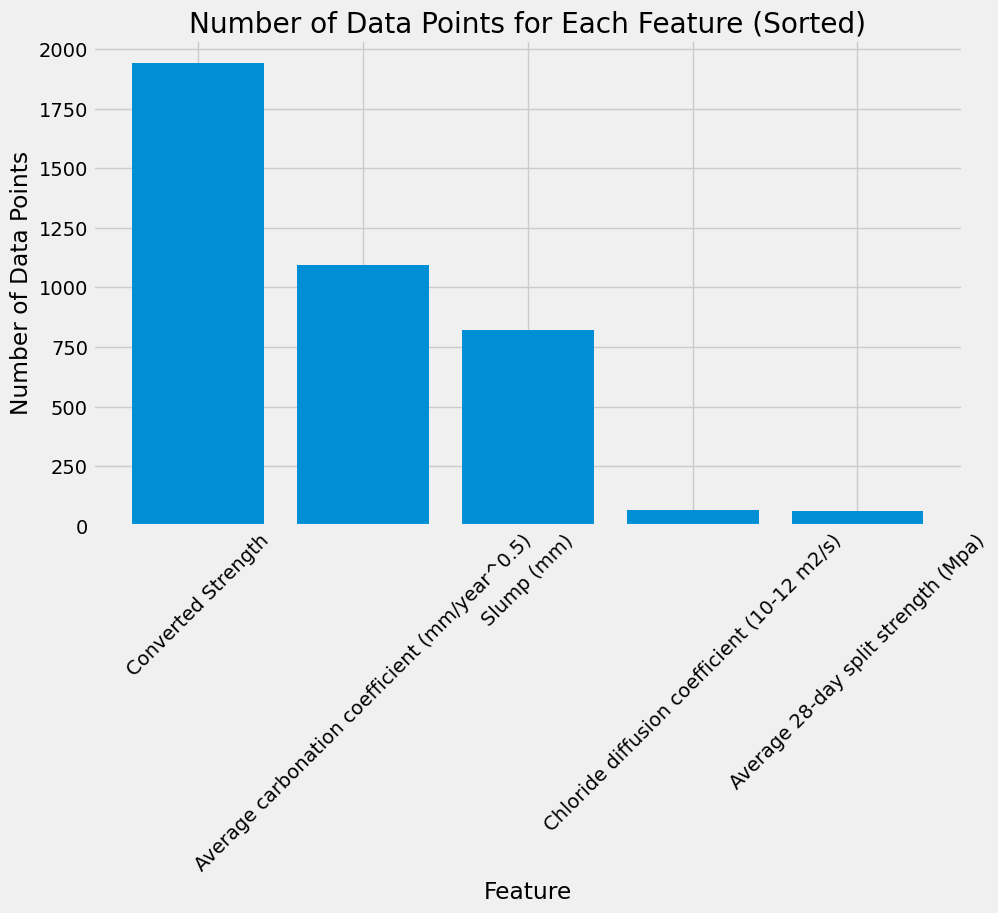

In [11]:
# Subset the DataFrame with the columns of interest
subset_df = semi_df[['Slump (mm)', 'Average 28-day split strength (Mpa)',
                     'Chloride diffusion coefficient (10-12 m2/s)',
                     'Average carbonation coefficient (mm/year^0.5)',
                     'Converted Strength']]

# Calculate the number of data points for each feature
counts = subset_df.count()

# Sort the counts in descending order
sorted_counts = counts.sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_counts.index, sorted_counts.values)

# Set plot labels and title
plt.xlabel('Feature')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points for Each Feature (Sorted)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

# Curing method

In [12]:
missing = semi_df['Curing method'].isnull()
semi_df[missing]

,ASTM type 1 ordinary Portland Cement content (kg/m^3),CEM I 42.5N ordinary Portland Cement content (kg/m^3),CEM I 52.5N ordinary Portland Cement content (kg/m^3),Class C Fly ash content (kg/m^3),Class F Fly ash content (kg/m^3),Slag content (kg/m^3),Silica fume content (kg/m^3),Water content (kg/m^3),Superplasticizer content (kg/m^3),Maximum coarse aggregate size (mm),Coarse aggregate content (kg/m^3),Fine aggregate content (kg/m^3),Curing method,Curing temperature (Celsius degree),Curing day,Slump (mm),Average 28-day split strength (Mpa),Chloride diffusion coefficient (10-12 m2/s),Average carbonation coefficient (mm/year^0.5),Converted Strength
1946,0.0,450.0,0.0,0.0,0.0,0.0,0.0,171.0,5.130,9.5,1110.0,680.0,NaN,NaN,NaN,65.0,NaN,NaN,NaN,NaN
1947,0.0,405.0,0.0,0.0,0.0,0.0,45.0,171.0,5.850,9.5,1101.0,675.0,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN
1948,0.0,337.5,0.0,0.0,0.0,112.5,0.0,171.0,5.850,9.5,1105.0,677.0,NaN,NaN,NaN,200.0,NaN,NaN,NaN,NaN
1949,0.0,292.5,0.0,0.0,0.0,112.5,45.0,171.0,5.895,9.5,1096.0,672.0,NaN,NaN,NaN,90.0,NaN,NaN,NaN,NaN
1950,0.0,225.0,0.0,0.0,0.0,225.0,0.0,171.0,5.400,9.5,1100.0,674.0,NaN,NaN,NaN,35.0,NaN,NaN,NaN,NaN
1951,0.0,180.0,0.0,0.0,0.0,225.0,45.0,171.0,5.850,9.5,1091.0,669.0,NaN,NaN,NaN,130.0,NaN,NaN,NaN,NaN
1952,0.0,135.0,0.0,0.0,0.0,315.0,0.0,171.0,4.230,9.5,1111.0,681.0,NaN,NaN,NaN,155.0,NaN,NaN,NaN,NaN
1953,0.0,90.0,0.0,0.0,0.0,315.0,45.0,171.0,5.850,9.5,1102.0,675.0,NaN,NaN,NaN,110.0,NaN,NaN,NaN,NaN


In [13]:
semi_df = semi_df.dropna(subset = ['Curing method'])
new_df = semi_df.copy()
new_df = pd.concat([semi_df, pd.get_dummies(semi_df['Curing method'])], axis=1)
new_df.isnull().sum()

ASTM type 1 ordinary Portland Cement content (kg/m^3)       0
CEM I 42.5N ordinary Portland Cement content (kg/m^3)       0
CEM I 52.5N ordinary Portland Cement content (kg/m^3)       0
Class C Fly ash content (kg/m^3)                            0
Class F Fly ash content (kg/m^3)                            0
Slag content (kg/m^3)                                       0
Silica fume content (kg/m^3)                                0
Water content (kg/m^3)                                      0
Superplasticizer content (kg/m^3)                           0
Maximum coarse aggregate size (mm)                          0
Coarse aggregate content (kg/m^3)                           5
Fine aggregate content (kg/m^3)                             5
Curing method                                               0
Curing temperature (Celsius degree)                         0
Curing day                                                  2
Slump (mm)                                               1168
Average 

In [14]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1980 entries, 0 to 1987
Data columns (total 24 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   ASTM type 1 ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 1   CEM I 42.5N ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 2   CEM I 52.5N ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 3   Class C Fly ash content (kg/m^3)                       1980 non-null   float64
 4   Class F Fly ash content (kg/m^3)                       1980 non-null   float64
 5   Slag content (kg/m^3)                                  1980 non-null   float64
 6   Silica fume content (kg/m^3)                           1980 non-null   float64
 7   Water content (kg/m^3)                                 1980 non-null   float64
 8   Superplasticizer content (kg/m^3)               

In [15]:
new_df = new_df.drop(['Curing method', 'Curing day'], axis= 1)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1980 entries, 0 to 1987
Data columns (total 22 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   ASTM type 1 ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 1   CEM I 42.5N ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 2   CEM I 52.5N ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 3   Class C Fly ash content (kg/m^3)                       1980 non-null   float64
 4   Class F Fly ash content (kg/m^3)                       1980 non-null   float64
 5   Slag content (kg/m^3)                                  1980 non-null   float64
 6   Silica fume content (kg/m^3)                           1980 non-null   float64
 7   Water content (kg/m^3)                                 1980 non-null   float64
 8   Superplasticizer content (kg/m^3)               

# Data preparation

In [23]:
num = [13] + list(range(16, 18))
df = new_df.iloc[:, num]
df

,Slump (mm),Average carbonation coefficient (mm/year^0.5),Converted Strength
0,30.0,3.139,75.93
1,60.0,4.022,64.50
2,100.0,6.670,49.23
3,140.0,7.945,36.00
4,40.0,6.052,62.80
...,...,...,...
1983,NaN,NaN,NaN
1984,NaN,NaN,NaN
1985,NaN,NaN,NaN
1986,NaN,NaN,NaN


In [19]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

In [17]:
target

,Slump (mm),Average 28-day split strength (Mpa),Chloride diffusion coefficient (10-12 m2/s),Average carbonation coefficient (mm/year^0.5),Converted Strength
0,30.0,NaN,NaN,3.139,75.93
1,60.0,NaN,NaN,4.022,64.50
2,100.0,NaN,NaN,6.670,49.23
3,140.0,NaN,NaN,7.945,36.00
4,40.0,NaN,NaN,6.052,62.80
...,...,...,...,...,...
1983,NaN,NaN,1.550,NaN,NaN
1984,NaN,NaN,3.375,NaN,NaN
1985,NaN,NaN,1.000,NaN,NaN
1986,NaN,NaN,0.500,NaN,NaN


In [21]:
scaled_features

dtype('float64')

In [16]:
slump = pd.concat([pd.DataFrame(scaled_features), target.iloc[:, 0]], axis=1).dropna(axis=0, how='any').values
split_str = pd.concat([pd.DataFrame(scaled_features), target.iloc[:, 1]], axis=1).dropna(axis=0, how='any').values
chloride = pd.concat([pd.DataFrame(scaled_features), target.iloc[:, 2]], axis=1).dropna(axis=0, how='any').values
carbon = pd.concat([pd.DataFrame(scaled_features), target.iloc[:, 3]], axis=1).dropna(axis=0, how='any').values
comp_str = pd.concat([pd.DataFrame(scaled_features), target.iloc[:, 4]], axis=1).dropna(axis=0, how='any').values

In [17]:
X = [
    slump[:,:-1],
    split_str[:,:-1],
    chloride[:,:-1],
    carbon[:,:-1],
    comp_str[:,:-1]
]

Y = [
    slump[:,-1:],
    split_str[:,-1:],
    chloride[:,-1:],
    carbon[:,-1:],
    comp_str[:,-1:]
]

In [19]:
T = len(Y) # Number of tasks
O = [y.shape[1] for y in Y] # Number of output per task
D = [x.shape[1] for x in X] # Dimension of the feature vector

## Train test split

In [20]:
X_train = []
Y_train = []
X_test = []
Y_test = []

from sklearn.model_selection import train_test_split
for sub_task in range(T):
    x_train, x_test, y_train, y_test = train_test_split(X[sub_task], Y[sub_task], test_size=0.2, random_state=42)
    X_train.append(x_train)
    Y_train.append(y_train)
    X_test.append(x_test)
    Y_test.append(y_test)

# Modle building

In [27]:
H1 = 128
H2 = 64
H3 = 32

epoch = 2000

In [22]:

# Define the model using the functional API
input_layers = [tf.keras.Input(shape=(d,)) for d in D]
hidden_1 = [tf.keras.layers.Dense(H1, activation='sigmoid')(input_layer) for input_layer in input_layers]
hidden_2 = [tf.keras.layers.Dense(H2, activation='sigmoid')(hidden_1_layer) for hidden_1_layer in hidden_1]

# Add the new hidden layer
hidden_3 = [tf.keras.layers.Dense(H3, activation='sigmoid')(hidden_2_layer) for hidden_2_layer in hidden_2]

outputs = [tf.keras.layers.Dense(o)(hidden_3_layer) for hidden_3_layer, o in zip(hidden_3, O)]

model = tf.keras.Model(inputs=input_layers, outputs=outputs)

In [25]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), loss='mse', metrics = [tf.keras.metrics.RootMeanSquaredError()])

In [28]:
# Train the model
best_loss = np.inf
best_epoch = 0

for current_epoch in range(epoch):
    model.train_on_batch(X_train, Y_train)
    train_loss_value = model.evaluate(X_train, Y_train, verbose=0)
    test_loss_value = model.evaluate(X_test, Y_test, verbose=0)
    
    if test_loss_value < best_loss:
        best_loss = test_loss_value
        best_epoch = current_epoch
    
    if current_epoch % 1000 == 0:
        print("Epoch:", current_epoch)
        print("Train loss:", train_loss_value)
        print("Test loss:", test_loss_value)
        print("Best loss:", best_loss)

# Calculate predicted values after training
predicted_values = model.predict(X_test)

# Calculate R^2 score for each task and plot scatters
for i in range(T):
    X_plot_values = Y_test[i]
    Y_plot_values = predicted_values[i]
    r2 = r2_score(X_plot_values, Y_plot_values)
    
    plt.scatter(X_plot_values, Y_plot_values, label=f"Task {i + 1} (R^2: {r2:.4f})")
    plt.xlabel("Actual values")
    plt.ylabel("Predicted values")
    
    min_limit = min(X_plot_values.min(), Y_plot_values.min())
    max_limit = max(X_plot_values.max(), Y_plot_values.max())
    
    plt.plot([min_limit, max_limit], [min_limit, max_limit], 'k--', lw=2, label="Diagonal")
    plt.xlim(min_limit, max_limit)
    plt.ylim(min_limit, max_limit)
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.legend()

plt.show()

ValueError: Data cardinality is ambiguous:
  x sizes: 645, 45, 42, 876, 1549
  y sizes: 645, 45, 42, 876, 1549
Make sure all arrays contain the same number of samples.